In [138]:
# Вариант 15
# Функция: z = x * sin(y)  
# Ограничения: x(-p<=x<=p) y(-p<=y<=p) z(-3<=z<=3)

In [139]:
!pip install -U scikit-fuzzy

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import math
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from tabulate import tabulate
from numpy.random import randint
from random import random as rnd
from random import gauss, randrange
from operator import itemgetter

In [141]:
X_START = -math.pi
X_END = math.pi
Y_START = -math.pi
Y_END = math.pi
Z_START = -3
Z_END = 3

In [142]:
TERMS = 5
ANT_NUMBER = 10
GRAPH_NUMBER = 5
Q = 1 # Количество фермента у одного муравья
ALPHA = 0.5 # Коэффициент снижения интенсивности фермента

In [143]:
X_STEP = (abs(X_START) + abs(X_END)) / TERMS
Y_STEP = (abs(Y_START) + abs(Y_END)) / TERMS
Z_STEP = (abs(Z_START) + abs(Z_END)) / TERMS

X = np.arange(X_START, X_END + X_STEP, X_STEP)
Y = np.arange(Y_START, Y_END + Y_STEP, Y_STEP)
Z = np.arange(Z_START, Z_END + Z_STEP, Z_STEP)

X_mesh, Y_mesh = np.meshgrid(X, Y)
Z_mesh = Y_mesh * np.sin(X_mesh + Y_mesh)

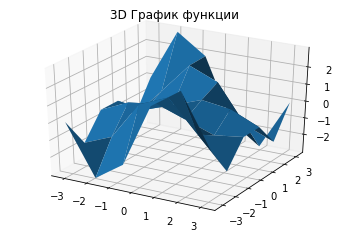

In [144]:
fix, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X_mesh,Y_mesh,Z_mesh)
ax.set_zlim()
plt.title('3D График функции')
plt.show(Z_START, Z_END)

In [145]:
def ranges(start, end, termsNum, variable):
    ranges = [None] * termsNum
    step = (abs(start) + abs(end)) / (termsNum - 1)

    label = "Функция принадлежности {} при {} термах".format(variable, termsNum)
    graph = ctrl.Antecedent(np.arange(start, end + step, step), label)

    for i in np.arange(0, termsNum, 1):
        triangle = []
        ranges[i] = {}

        if i == 0:
            triangle = [start, start, start + step]
            ranges[i]['start'] = triangle[1]
            ranges[i]['end'] = triangle[2] - (step / 2)
            ranges[i]['mid'] = triangle[1]
        else:
            triangle = [
                (i - 1) * step - abs(start),
                i * step - abs(start),
                (i + 1) * step - abs(start)
            ]
            if termsNum - 1 == i:
                ranges[i]['start'] = triangle[0] + (step / 2)
                ranges[i]['end'] = triangle[1]
                ranges[i]['mid'] = triangle[1]
            else:
                ranges[i]['start'] = triangle[0] + (step / 2)
                ranges[i]['end'] = triangle[2] - (step / 2)
                ranges[i]['mid'] = triangle[1]
        graph[i] = fuzz.trimf(graph.universe, triangle)
    graph.view()
    return ranges

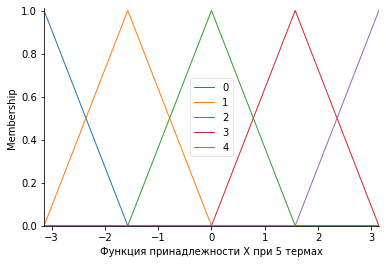

In [146]:
X_RANGES = ranges(X[0], X[-1], TERMS, 'Х')

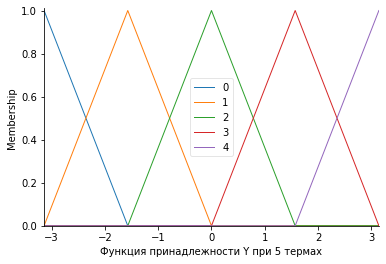

In [147]:
Y_RANGES = ranges(Y[0], Y[-1], TERMS, 'Y')

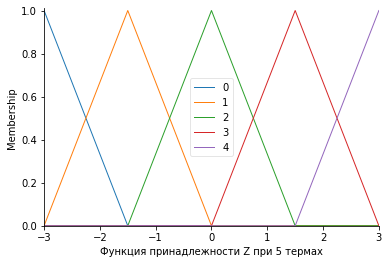

In [148]:
Z_RANGES = ranges(Z[0], Z[-1], TERMS, 'Z')

In [149]:
tableHeader = ['№', '1', '2', '3']
tableVariables = []

for i in range(TERMS):
    tableVariables.append([i + 1, X_RANGES[i]['start'], X_RANGES[i]['mid'], X_RANGES[i]['end']])

print('Параметры функции принадлежности:')
print(tabulate(tableVariables, tableHeader))

Параметры функции принадлежности:
  №          1         2          3
---  ---------  --------  ---------
  1  -3.14159   -3.14159  -2.35619
  2  -2.35619   -1.5708   -0.785398
  3  -0.785398   0         0.785398
  4   0.785398   1.5708    2.35619
  5   2.35619    3.14159   3.14159


In [150]:
def normalization(value, limitUpper, limitLower):
    return (value - limitLower) / (limitUpper - limitLower)

In [151]:
def denormalization(value, limitUpper, limitLower):
    return (value * (limitUpper - limitLower)) + limitLower

In [152]:
def findProbability(graph):
    graphWithPoss = []
    for i in range(len(graph)):
        graphWithPoss.append({
            'val': graph[i],
            'poss': 0
        })
    return graphWithPoss

In [153]:
def findGraph(termNumber):
    limitLower = X_RANGES[termNumber]['start']
    limitUpper = X_RANGES[termNumber]['end']

    if abs(limitUpper) > abs(limitLower):
        distance = abs(limitUpper) - abs(limitLower)
    elif abs(limitUpper) == abs(limitLower):
        distance = abs(limitUpper) + abs(limitLower)
    else:
        distance = abs(limitLower) - abs(limitUpper)
    
    step = distance/GRAPH_NUMBER
    graph = []
    for i in range(GRAPH_NUMBER):
        graph.append(limitLower + (i * step))

    return graph

In [154]:
def normalizationGraph(graph, termNumber):
    limitLower = X_RANGES[termNumber]['start']
    limitUpper = X_RANGES[termNumber]['end']
    graphNorm = [None] * len(graph)
    for i in range(len(graph)):
        graphNorm[i] = normalization(graph[i], limitUpper, limitLower)

    graphNormWithPoss = findProbability(graphNorm)
    return graphNormWithPoss

In [155]:
def firstFindNextPeak(graph, way):
    way0 = way[0]['val']
    need = 1 - way0
    randomNumber = randint(0, len(graph) - 1)

    while graph[randomNumber]['val'] == way[0]['val'] or \
          graph[randomNumber]['val'] > need:
        randomNumber = randint(0, len(graph) - 1)
    return graph[randomNumber]

In [156]:
def secondFindNextPeak(graph, way):
    need = 0
    way0 = way[0]['val']
    way1 = way[1]['val']
    need = round((1 - (way0 + way1)), 1)
    lastNeedNumber = 0

    for i in range(len(graph)):
        if graph[i]['val'] == need:
            lastNeedNumber = i
    return graph[lastNeedNumber]

In [157]:
def chooseWay(graph):
    way = []
    randomWay = randint(0, GRAPH_NUMBER - 1)
    way.append(graph[randomWay])
    way.append(firstFindNextPeak(graph, way))
    way.append(secondFindNextPeak(graph, way))
    return way

In [158]:
def formatDataToFuzzySystem(way, termNumber):
    limitLower = X_RANGES[termNumber]['start']
    limitUpper = X_RANGES[termNumber]['end']
    return  [
        denormalization(way[0]['val'], limitUpper, limitLower),
        denormalization(way[2]['val'], limitUpper, limitLower),
        denormalization(way[1]['val'], limitUpper, limitLower)
    ]

In [159]:
def calculateError(params, termNumber):
    skoSum = 0
    for i in range(3):
        skoSum += np.power((tableVariables[termNumber][i + 1] - params[i]), 2)
    sko = math.sqrt(skoSum/len(params))
    return sko

In [160]:
def evaporationPheroment(antWays):
    antWays[3]['pherment'] *= ALPHA
    return antWays

In [161]:
def addPheromentAndError(antWays, error):
    if antWays.__contains__('pherment'):
        antWays[3]['pherment'] += Q/error
        antWays[4]['error'] = error
    else:
        antWays.append({'pherment': Q/error})
        antWays.append({'error': error})
    return antWays

In [162]:
def findBestWayForTerm(ways, termNumber):
    start = termNumber * ANT_NUMBER
    end = start + ANT_NUMBER
    way = ways[start:end]
    best = way[0]
    for i in range(len(way)):
        if way[i][3]['pherment'] > best[3]['pherment']:
            best = way[i]
    return best

In [163]:
def denormalizationOptions(options):
    denormOptions = []
    for i in range(len(options)):
        optionsArr = [options[i][0], options[i][1], options[i][2]]
        fuzzy = formatDataToFuzzySystem(optionsArr, i)
        sortedFuzzy = sorted(fuzzy)
        denormOptions.append(sortedFuzzy)
    return denormOptions

In [164]:
def findBestWays():
    antWays = []
    bestWays = []
    for i in range(TERMS):
        print("~~~~~~~~~~~~~~~~Колония №", i + 1)
        print("")

        for j in range(ANT_NUMBER):
            print("Муравей №", j + 1)

            graph = findGraph(i)
            print("Значения в вершинах графа: ", graph)

            graphNorm = normalizationGraph(graph, i)
            print("Нормированные значения графа: ", graphNorm)

            ant = chooseWay(graphNorm)
            print("Путь выбранный муравьем: ", ant)

            sortedAntWays = sorted(ant, key = lambda x: x['val'])
            fuzzy = formatDataToFuzzySystem(sortedAntWays, i)

            error = calculateError(fuzzy, i)
            print("Ошибка: ", error)

            ant = addPheromentAndError(ant, error)
            print('Путь муравья с ферментом и ошибкой: ', ant)

            ant = evaporationPheroment(ant)
            print("После испарения ферамента: ", ant)

            antWays.append(ant)
            print("")

        bestWays.append(findBestWayForTerm(antWays, i))
        print("\n-----------------------------------------\n")
    return bestWays

In [165]:
bestWays = findBestWays()
print('Результат операции:', bestWays)

~~~~~~~~~~~~~~~~Колония № 1

Муравей № 1
Значения в вершинах графа:  [-3.141592653589793, -2.9845130209103035, -2.827433388230814, -2.670353755551324, -2.5132741228718345]
Нормированные значения графа:  [{'val': 0.0, 'poss': 0}, {'val': 0.2, 'poss': 0}, {'val': 0.4, 'poss': 0}, {'val': 0.6, 'poss': 0}, {'val': 0.8, 'poss': 0}]
Путь выбранный муравьем:  [{'val': 0.6, 'poss': 0}, {'val': 0.4, 'poss': 0}, {'val': 0.0, 'poss': 0}]
Ошибка:  0.38476494904855923
Путь муравья с ферментом и ошибкой:  [{'val': 0.6, 'poss': 0}, {'val': 0.4, 'poss': 0}, {'val': 0.0, 'poss': 0}, {'pherment': 2.598989337445587}, {'error': 0.38476494904855923}]
После испарения ферамента:  [{'val': 0.6, 'poss': 0}, {'val': 0.4, 'poss': 0}, {'val': 0.0, 'poss': 0}, {'pherment': 1.2994946687227935}, {'error': 0.38476494904855923}]

Муравей № 2
Значения в вершинах графа:  [-3.141592653589793, -2.9845130209103035, -2.827433388230814, -2.670353755551324, -2.5132741228718345]
Нормированные значения графа:  [{'val': 0.0, 'po

In [166]:
bestWaysDenormalized = denormalizationOptions(bestWays)
print("Денормализованные значения: ", bestWaysDenormalized)

Денормализованные значения:  [[-3.141592653589793, -2.827433388230814, -2.670353755551324], [-2.356194490192345, -1.7278759594743862, -1.413716694115407], [-0.7853981633974483, -0.15707963267948966, 0.15707963267948966], [0.7853981633974483, 1.413716694115407, 1.7278759594743862], [2.356194490192345, 2.670353755551324, 2.827433388230814]]
